# Dependencies

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score

%matplotlib inline

# Dataset Loading

In [2]:
df = pd.read_csv('BitcoinHeistData.csv') 

In [3]:
df.head()


,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000.0,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000.0,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky


In [20]:
df.shape

(2916697, 10)

In [22]:
df[['length','weight','count','looped','neighbors','income']].describe()

,length,weight,count,looped,neighbors,income
count,2.916697e+06,2.916697e+06,2.916697e+06,2.916697e+06,2.916697e+06,2.916697e+06
mean,4.500859e+01,5.455192e-01,7.216446e+02,2.385067e+02,2.206516e+00,4.464889e+09
std,5.898236e+01,3.674255e+00,1.689676e+03,9.663217e+02,1.791877e+01,1.626860e+11
min,0.000000e+00,3.606469e-94,1.000000e+00,0.000000e+00,1.000000e+00,3.000000e+07
25%,2.000000e+00,2.148438e-02,1.000000e+00,0.000000e+00,1.000000e+00,7.428559e+07
50%,8.000000e+00,2.500000e-01,1.000000e+00,0.000000e+00,2.000000e+00,1.999985e+08
75%,1.080000e+02,8.819482e-01,5.600000e+01,0.000000e+00,2.000000e+00,9.940000e+08
max,1.440000e+02,1.943749e+03,1.449700e+04,1.449600e+04,1.292000e+04,4.996440e+13


# Data exploration

### 1. les périodes de fortes attaques

**Quelles sont les périodes de l'année où les ransomwares ont été les plus actifs ? Cela permet d’identifier des vagues d’attaques ou des pics de ransomware.**

C:\Users\akdio\AppData\Local\Temp\ipykernel_3848\3277701847.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ransom['date'] = pd.to_datetime('2020-01-01') + pd.to_timedelta(df_ransom['day'], unit='D')


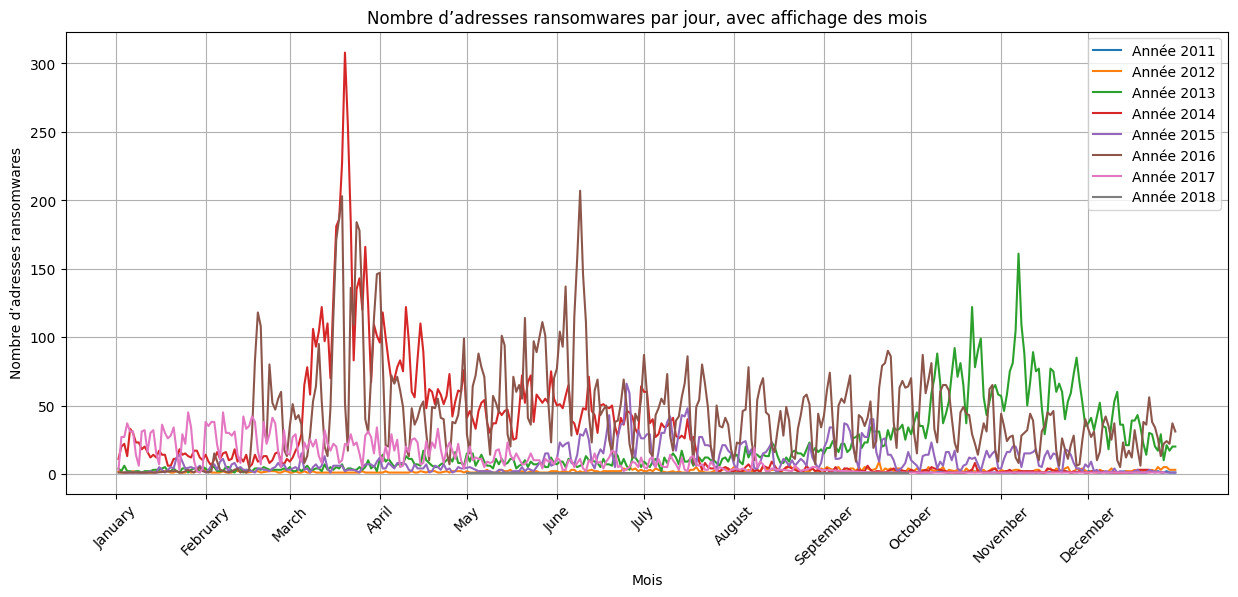

In [5]:
# Filtrer les ransomwares
df_ransom = df[df['label'] != 'white']

# Créer une date fictive (année fixe genre 2020) pour l’affichage, avec "day" = jour de l’année
df_ransom['date'] = pd.to_datetime('2020-01-01') + pd.to_timedelta(df_ransom['day'], unit='D')

# Grouper pour compter le nombre d’adresses par jour réel
daily_counts = df_ransom.groupby(['year', 'date']).size().reset_index(name='count')

# Plot
plt.figure(figsize=(15,6))

for year in daily_counts['year'].unique():
    subset = daily_counts[daily_counts['year'] == year]
    plt.plot(subset['date'], subset['count'], label=f'Année {year}')

# Customisation de l’axe X pour afficher les mois
plt.gca().set_xticks(pd.date_range(start='2020-01-01', end='2020-12-31', freq='MS'))  # MS = Month Start
plt.gca().set_xticklabels(pd.date_range(start='2020-01-01', end='2020-12-31', freq='MS').strftime('%B'))

# Ajouter légendes et titres
plt.xlabel('Mois')
plt.ylabel('Nombre d’adresses ransomwares')
plt.title('Nombre d’adresses ransomwares par jour, avec affichage des mois')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


**Conclusion : Périodes intenses en ransomware entre mars et avril et entre octobre et décembre**

### Identifier les montants typiques des rançons

**Quels sont les montants récurrents des transactions ransomwares ? Cela aide à poser des seuils de détection automatique.**

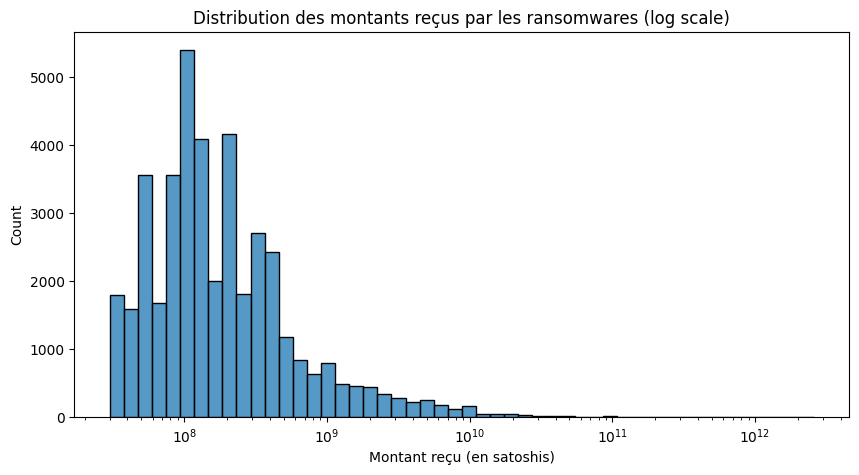

In [ ]:
df_ransom = df[df['label'] != 'white']

plt.figure(figsize=(10,5))
sns.histplot(df_ransom['income'], bins=50, log_scale=True)
plt.title("Distribution des montants des transactions (log scale)")
plt.xlabel("Montant reçu (en satoshis)")
plt.show()


**Conclusion : vu cela, on peux définir une règle métier :**

**Toute adresse recevant exactement l'une des dix valeurs citées en bas comme montant est suspecte**

**Exemple : Toute adresse recevant exactement 2595000000000 satoshis = suspect.**

**Cette analyse révèle les tarifs standards des ransomwares connus.** 

In [57]:
# les 10 max plus grandes sommes reçues par les ransomwares
df[df['label'] != 'white']['income'].nlargest(10)

23630    2.595000e+12
2448     4.450000e+11
2377     4.280654e+11
2436     4.276306e+11
2412     2.761544e+11
2395     2.727897e+11
2376     2.547097e+11
2396     2.450600e+11
2403     1.931079e+11
2371     1.902508e+11
Name: income, dtype: float64

### Identifier les adresses fortement connectées (hubs)

**Quels sont les hubs transactionnels, c’est-à-dire les adresses qui reçoivent/envoyent à un très grand nombre d’autres adresses ? Ces hubs peuvent être soit des exchanges légitimes, soit des mécanismes de blanchiment.**

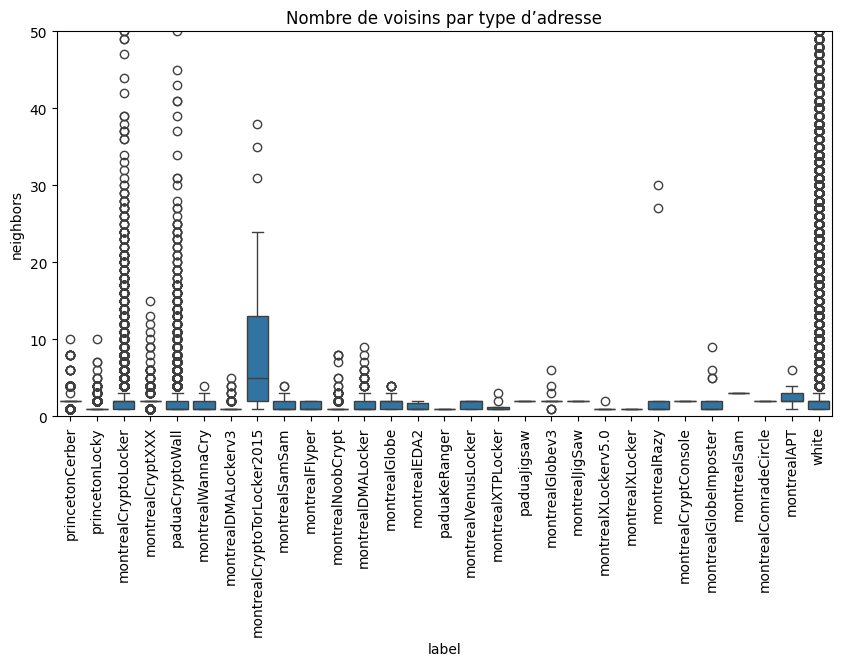

In [58]:
plt.figure(figsize=(10,5))
sns.boxplot(x='label', y='neighbors', data=df)
plt.title("Nombre de voisins par type d’adresse")
plt.ylim(0, 50)  
plt.xticks(rotation=90)  
plt.show()


In [11]:
df[df['label'] == 'montrealCryptoTorLocker2015']['neighbors'].median()

np.float64(5.0)

**Conclusion : une adresse avec >= 5 voisins a une forte probabilité d’être une adresse suspecte, surtout si elle reçoit des montants typiques de rançon.**

### Détection de comportements suspects (activité intense en peu de temps)

**Peut-on détecter des adresses qui reçoivent un nombre anormal de paiements sur une courte période ? Cela correspond à des adresses de collecte massives, typiques de certaines campagnes de ransomware.**

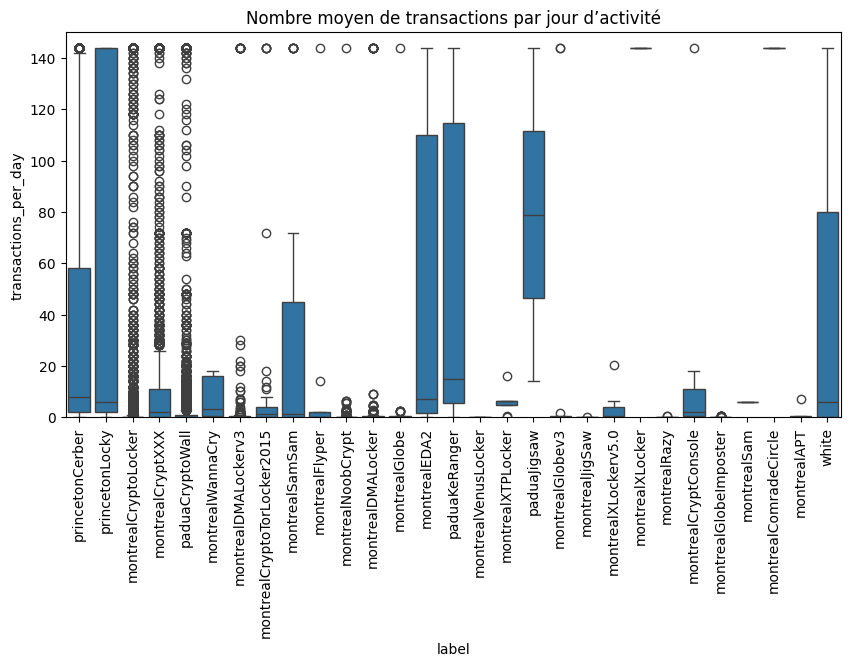

In [59]:
ddf = df.copy()

ddf['transactions_per_day'] = ddf['length'] / ddf.groupby('address')['day'].transform(lambda x: x.max() - x.min() + 1) # nombre de transactions par jour d’activité

plt.figure(figsize=(10,5))
sns.boxplot(x='label', y='transactions_per_day', data=ddf)
plt.title("Nombre moyen de transactions par jour d’activité")
plt.ylim(0, 150)
plt.xticks(rotation=90)  # Bonne méthode pour pivoter les ticks
plt.show()


**Conclusion: Si les ransomwares ont une très forte densité transactionnelle sur quelques jours, c’est typique des campagnes ciblées, ce critère peut devenir une règle métier : "Si une adresse a > 50 transactions par jour, alerte !"**

### Identifier les schémas de blanchiment (looped)

**Les ransomwares utilisent-ils des techniques de recyclage de fonds (boucles) pour brouiller les pistes ?**

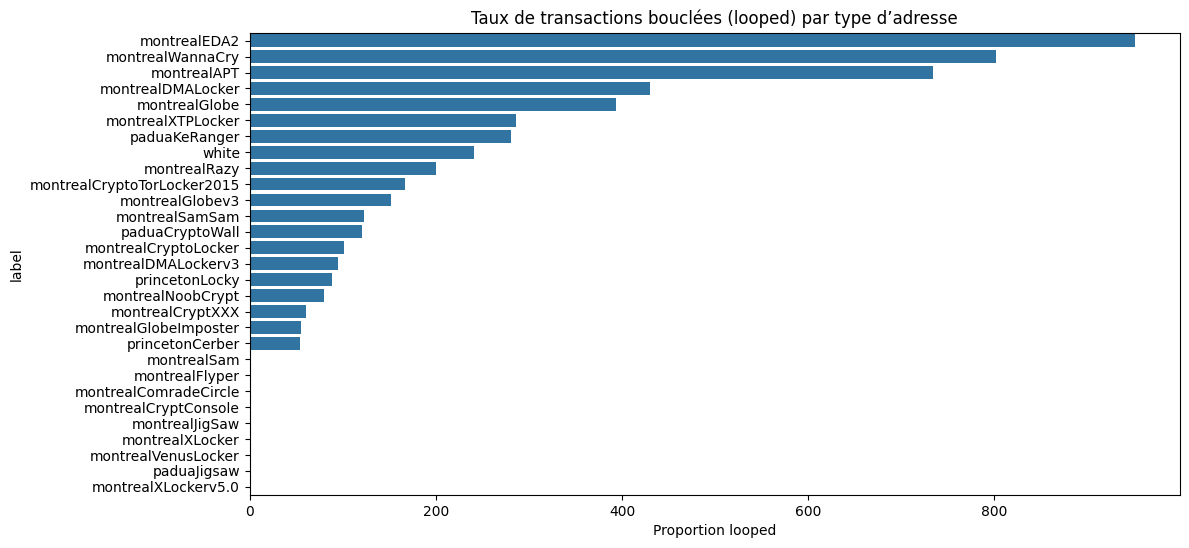

In [26]:
# Calculer le taux de looped (proportion d’adresses looped) par type d’adresse
looped_rate = df.groupby('label')['looped'].mean().reset_index()

# Trier par taux de looped pour meilleure lisibilité
looped_rate = looped_rate.sort_values(by='looped', ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x='looped', y='label', data=looped_rate)
plt.title("Taux de transactions bouclées (looped) par type d’adresse")
plt.xlabel("Proportion looped")
plt.show()


**Conclusion: Si les adresses ransomwares bouclent leurs transactions beaucoup plus souvent que les légitimes (>= 300), c’est un signal fort. Peut devenir une règle : "Si une adresse looped + faible nombre de voisins + montant standard, forte alerte !"**

# Preprocessing

### **Sous échantillonage**

In [14]:
print('Nombre de transactions légitimes :', len(df[df['label'] == 'white']))
print('Nombre de transactions ransomware :', len(df[df['label'] != 'white']))

Nombre de transactions légitimes : 2875284
Nombre de transactions ransomware : 41413


**Problème 99% des transactions sont légitimes!**
**Entraîner un modèle de ML sur ce dataset pour prédire la légitimité des transactions est un défi, pour palier ce probèlme nous allons sous échantillonner les transactions légitimes, afin d'équilibrer les proportions des deux cas, nous décidons donc de considérer seulement 100K transactions légitimes faces à 41K ransomwares**

In [28]:
df_sample = df[df['label'] == 'white'].sample(100000)

In [29]:
df_sample = pd.concat([df_sample, df[df['label'] != 'white']])

In [30]:
df_sample

,address,year,day,length,weight,count,looped,neighbors,income,label
1404104,1PbpjzjudMvDXyGWnNyvVYeWF8J5b6p1ye,2014,278,2,0.015625,1,0,1,5.738434e+07,white
1669357,1AJWu3FHm7Edc6V1qaAmt47qSAXrBu8Znv,2015,178,0,1.000000,1,0,2,1.337011e+08,white
1075003,1MM75yKwC4VQkNP9Ysjog3np64gRQmoVXX,2013,314,16,1.000000,1,0,2,7.340220e+08,white
1807898,1DcwXR29SMCgTqvvySwFRghoZHHuqcjTRb,2015,317,144,0.289186,6286,6206,2,2.000000e+09,white
490717,1MdQpUCWAjXqtj7Awvdit8UQoqa39abZXj,2012,95,4,0.875000,3,0,2,1.250000e+10,white
...,...,...,...,...,...,...,...,...,...,...
41408,35iCvpMMnUWcSWrYtLJLXqe9xo5CYEWRhw,2017,76,144,1.375002,8076,8073,6,5.726876e+08,montrealAPT
41409,377CY1m8W2qbQQX5HHjziimdh2faGjDeLv,2016,259,2,1.500000,2,0,2,7.449526e+07,montrealAPT
41410,377CY1m8W2qbQQX5HHjziimdh2faGjDeLv,2016,277,0,0.500000,1,0,2,5.714286e+07,montrealAPT
41411,377CY1m8W2qbQQX5HHjziimdh2faGjDeLv,2016,271,6,0.125000,1,0,2,1.000000e+08,montrealAPT


In [31]:
# Faire un shuffle des données après concaténation des deux sous-ensembles

df_sample = df_sample.sample(frac=1).reset_index(drop=True)
df_sample


,address,year,day,length,weight,count,looped,neighbors,income,label
0,1EVS68C21WSuEzcf1wTmA2qP94hkw8jRCD,2018,310,144,0.787590,4249,0,2,1.000000e+08,white
1,1PFiigjZ74pmx5am9XmD17BM5i8M9rw5VR,2015,340,4,0.500000,1,0,2,5.631024e+07,white
2,1Nqr3MqVyUp6k3o3QPePAdn4Yg4tzgB9kw,2011,14,22,1.000488,3,0,3,3.500000e+09,white
3,1ENh6T3vSVCV7LEQzRkCGVH3A51TfTs9mu,2015,195,144,0.016564,1527,0,1,1.790000e+08,paduaCryptoWall
4,1M2cfux6gdbypPkqJtET4txSeDh5Ynp1Je,2016,249,38,0.000088,12,0,2,5.960000e+07,white
...,...,...,...,...,...,...,...,...,...,...
141408,1BEFLvXryUj2qYLf5SmSC1HPvqvxDWGEcf,2013,321,144,0.151020,1536,0,1,1.004300e+08,white
141409,15pWMYtJyaZwowhpsjK7kPmsi6eny984Mc,2016,226,0,0.500000,1,0,1,2.000000e+08,princetonLocky
141410,14RLgxJaVGvnBBUSQHHkx8fgYPqzYZqcxW,2017,246,0,0.500000,1,0,2,4.427540e+07,white
141411,14t47exAFFtxhy1yU9855sY3ZdS3teNdpi,2016,357,20,0.031250,2,0,2,1.232787e+08,white


### **Feature engineering**

In [32]:
df_sample['transactions_per_day'] = df_sample['length'] / df_sample.groupby('address')['day'].transform(lambda x: x.max() - x.min() + 1)
df_sample

,address,year,day,length,weight,count,looped,neighbors,income,label,transactions_per_day
0,1EVS68C21WSuEzcf1wTmA2qP94hkw8jRCD,2018,310,144,0.787590,4249,0,2,1.000000e+08,white,144.000000
1,1PFiigjZ74pmx5am9XmD17BM5i8M9rw5VR,2015,340,4,0.500000,1,0,2,5.631024e+07,white,4.000000
2,1Nqr3MqVyUp6k3o3QPePAdn4Yg4tzgB9kw,2011,14,22,1.000488,3,0,3,3.500000e+09,white,0.194690
3,1ENh6T3vSVCV7LEQzRkCGVH3A51TfTs9mu,2015,195,144,0.016564,1527,0,1,1.790000e+08,paduaCryptoWall,1.082707
4,1M2cfux6gdbypPkqJtET4txSeDh5Ynp1Je,2016,249,38,0.000088,12,0,2,5.960000e+07,white,38.000000
...,...,...,...,...,...,...,...,...,...,...,...
141408,1BEFLvXryUj2qYLf5SmSC1HPvqvxDWGEcf,2013,321,144,0.151020,1536,0,1,1.004300e+08,white,144.000000
141409,15pWMYtJyaZwowhpsjK7kPmsi6eny984Mc,2016,226,0,0.500000,1,0,1,2.000000e+08,princetonLocky,0.000000
141410,14RLgxJaVGvnBBUSQHHkx8fgYPqzYZqcxW,2017,246,0,0.500000,1,0,2,4.427540e+07,white,0.000000
141411,14t47exAFFtxhy1yU9855sY3ZdS3teNdpi,2016,357,20,0.031250,2,0,2,1.232787e+08,white,20.000000


`transactions_per_day` représente le **nombre moyen de transactions réalisées par jour d’activité pour chaque adresse**.
Les ransomwares ont souvent une activité très concentrée sur une période courte (pics d’activité), alors que les adresses légitimes ont une activité plus régulière. Cette variable permet donc de capturer ce signal comportemental, très utile pour différencier les comportements normaux et suspects.

### **Feature selection**

In [34]:
# Supprimer les colonnes inutiles, comme adress, year et day

df_sample.drop(columns=['address', 'year', 'day'], inplace=True)

In [35]:
df_sample.head(10)

,length,weight,count,looped,neighbors,income,label,transactions_per_day
0,144,0.787590,4249,0,2,1.000000e+08,white,144.000000
1,4,0.500000,1,0,2,5.631024e+07,white,4.000000
2,22,1.000488,3,0,3,3.500000e+09,white,0.194690
3,144,0.016564,1527,0,1,1.790000e+08,paduaCryptoWall,1.082707
4,38,0.000088,12,0,2,5.960000e+07,white,38.000000
5,144,0.661295,3914,0,2,7.480000e+07,white,144.000000
6,144,0.000003,1242,1241,2,4.914000e+07,white,144.000000
7,0,1.000000,1,0,1,7.405000e+07,white,0.000000
8,0,0.500000,1,0,2,2.000000e+08,princetonCerber,0.000000
9,2,1.000000,1,0,2,1.664600e+08,princetonCerber,2.000000


### **Encodage de la varaible catégorique ''label''**

In [36]:
# 0 pour les transactions légitimes, 1 pour les ransomwares

df_sample['label'] = df_sample['label'].apply(lambda x: 0 if x == 'white' else 1)

In [37]:
df_sample

,length,weight,count,looped,neighbors,income,label,transactions_per_day
0,144,0.787590,4249,0,2,1.000000e+08,0,144.000000
1,4,0.500000,1,0,2,5.631024e+07,0,4.000000
2,22,1.000488,3,0,3,3.500000e+09,0,0.194690
3,144,0.016564,1527,0,1,1.790000e+08,1,1.082707
4,38,0.000088,12,0,2,5.960000e+07,0,38.000000
...,...,...,...,...,...,...,...,...
141408,144,0.151020,1536,0,1,1.004300e+08,0,144.000000
141409,0,0.500000,1,0,1,2.000000e+08,1,0.000000
141410,0,0.500000,1,0,2,4.427540e+07,0,0.000000
141411,20,0.031250,2,0,2,1.232787e+08,0,20.000000


# Modeling

**Le modèle que nous allons retenir et qui nous a semblé mieux performer est Xgboost, c'est un modèle à base des arbres de décision, ne nécessitant pas de standardisation lors du preprocessing**

In [38]:
features = ['length', 'weight', 'count', 'looped', 'neighbors', 'income', 'transactions_per_day']

X = df_sample[features]
y = df_sample['label']

### **Séparation en données d'entraînement et données de test**

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Le modèle Xgboost a des hyperparamètres qu'on doit ajuster tels n_estimators, max_depth, etc. Afin d'automatiser cette tâche, nous allons procéder à une cross validation**

In [ ]:
# Le grid search va tester toutes plein de combinaisons possibles sur n_estimators & max_depth pour trouver les meilleures
param_grid = {
    'n_estimators': [50, 100, 150, 200],               
    'max_depth': [3, 5, 6, 7],                        
}


### **Instancier le modèle**

In [ ]:
# Initialisation du modèle
xgb = XGBClassifier(random_state=42, use_label_encoder=False)

# Création de GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=make_scorer(f1_score), 
    cv=3,                            # 3 fold 
    verbose=1,
    n_jobs=-1                        # Parallélisation (utiliser tous les cœurs disponibles)
)

# Le nombre d'itérations est égale à 4 (n_estimators) * 4(max_depth) * 3 (folds) = 48

In [44]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


c:\Users\akdio\Desktop\BITCOIN\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [15:49:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7],
                         'n_estimators': [50, 100, 150, 200]},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=1)

In [45]:
print("Meilleurs hyperparamètres trouvés :", grid_search.best_params_)

Meilleurs hyperparamètres trouvés : {'max_depth': 6, 'n_estimators': 150}


In [46]:
best_model = grid_search.best_estimator_

# Prédictions et évaluation finale
y_pred = best_model.predict(X_test)

### **Matrice de confusion**

In [48]:
confusion_matrix(y_test, y_pred)

array([[18816,  1184],
       [ 2311,  5972]])

### **classification_report**

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92     20000
           1       0.83      0.72      0.77      8283

    accuracy                           0.88     28283
   macro avg       0.86      0.83      0.84     28283
weighted avg       0.87      0.88      0.87     28283



# Résultats

### **Analyse de la matrice de confusion**

18816 = Vrais Négatifs (white bien prédit comme white)

1184 = Faux Positifs (white prédit à tort comme ransomware)

2311 = Faux Négatifs (ransomware prédit à tort comme white)

5972 = Vrais Positifs (ransomware bien prédit comme ransomware)

### **Interprétation du classification_report**

**Classe 0 (white - légitime)**

Précision = 0.89 : Quand le modèle dit "white", il a raison 89% du temps.

Recall = 0.94 : Sur toutes les adresses white existantes, il en trouve 94%.

F1 = 0.92 : Bon compromis entre précision et rappel.

Excellente détection des adresses normales mais l'objectif c'est l'autre classe!

**Classe 1 (ransomware - suspect)**

Précision = 0.83 : Quand le modèle dit "ransomware", il a raison 83% du temps.

Recall = 0.72 : Sur tous les vrais ransomwares, il en détecte seulement 72% :(

F1 = 0.77 : Ce score montre que le modèle a encore du mal à bien capter tous les ransomwares.

Il reste un risque de faux négatifs : des ransomwares passent entre les mailles!!

### **Recommandations pour améliorer**

Ajuster le threshold de décision: rendre les critère trouvés suite à "Data exploration" un peu plus sévères afin de remédier la fuite des 28% des faux négatifs

Enrichir les features : Ajouter d’autres signaux temporels, des métriques réseau (centralité, chaîne de paiements, etc.).

Essayer des techniques de sur-échantillonnage (SMOTE): renforcement learning pour augmenter le nombre d'échantillons de la classe minoritaire


# Sauvegarde du modèle

In [61]:
import joblib
# Enregistrer le modèle entraîné 
joblib.dump(best_model, 'xgboost_ransomware_model.joblib')

print("Modèle sauvegardé sous 'xgboost_ransomware_model.joblib'")

Modèle sauvegardé sous 'xgboost_ransomware_model.joblib'
